In [47]:
import pandas as pd
import ast
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw

In [ ]:
data = pd.read_csv("all_chem_df.csv")
data = data.drop(["image_name", "Col3"], axis=1)
data = data[sorted(data.columns)]
data["tags"] = data["tags"].apply(ast.literal_eval)
data_exploded = data.explode("tags")
data_exploded

ValueError: malformed node or string on line 1: <ast.Name object at 0x3589c5410>

In [24]:
dataReduced = data[:4000]
dataReduced

,smiles,tags
0,CC(=O)NC1C(O)OC(CO)C(O)C1O,dermatologic
1,CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...,antiinfective
2,CCCCC(C)C(=O)OC1C(C)C(CC)OC2(CC3CC(C/C=C(\C)CC...,antiinfective
3,COc1cc2c(c(OC)c1OC)-c1c(cc3c(c1OC)OCO3)C[C@H](...,antineoplastic
4,CC(=O)N[C@@H](CS)C(=O)[O-],antiinfective respiratorysystem
...,...,...
3995,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,gastrointestinal
3996,C=CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(=NO)c3csc(N)n3...,antiinfective
3997,COc1cc(C(=O)OCCCN2CCCN(CCCOC(=O)c3cc(OC)c(OC)c...,cardio
3998,Clc1cccc(C(c2ccc3nc[nH]c3c2)n2ccnc2)c1,dermatologic antineoplastic


In [25]:
compounds = []
for _, smiles in data["smiles"].items():
    compounds.append(Chem.MolFromSmiles(smiles))

[13:06:53] Conflicting single bond directions around double bond at index 1.
[13:06:53]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] Conflicting single bond directions around double bond at index 1.
[13:06:53]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:53] WARNING: not removing hydrogen atom without neighbors
[13:06:54] Conflicting single bond directions around double bond at index 1.
[13:06:54]   BondStereo set to STEREONONE and single bond directions set to NONE.
[13

In [26]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fingerprints = [rdkitGen.GetFingerprint(mol) for mol in compounds]

In [27]:
print(f"Number of compounds converted: {len(fingerprints)}")
print(f"Fingerprint length per compound: {len(fingerprints[0])}")

Number of compounds converted: 8336
Fingerprint length per compound: 1024


In [28]:
def tanimotoDistanceMatrix(fpList):
    """
    generate Tanimoto distance matrix
    input: list of fingerprints
    output: matrix of distances between each molecule
    """
    dissimilarityMatrix = []
    for i in range (1, len(fpList)):
        similarities = DataStructs.BulkTanimotoSimilarity(fpList[i], fpList[:i])
        dissimilarityMatrix.extend([1 - x for x in similarities])
    return dissimilarityMatrix

def clusterFingerprints(fingerprints, cutoff):
    """cluster fingerprints using Butina based on pre-set cutoff
    input: list of fingerprints, cutoff[0;1]
    output: a tuple of tuples containing information about the clusters; first element for each cluster is its centroid
    *higher cutoff = less clusters, bigger diversity within a cluster
    """
    distanceMatrix = tanimotoDistanceMatrix(fingerprints)
    clusters = Butina.ClusterData(distanceMatrix, len(fingerprints), cutoff, isDistData = True)
    clusters = sorted(clusters, key = len, reverse = True)
    return clusters

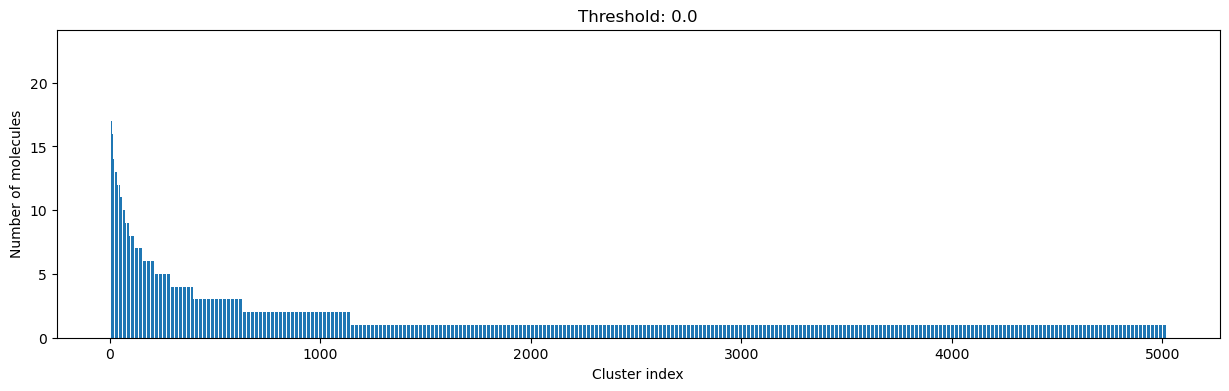

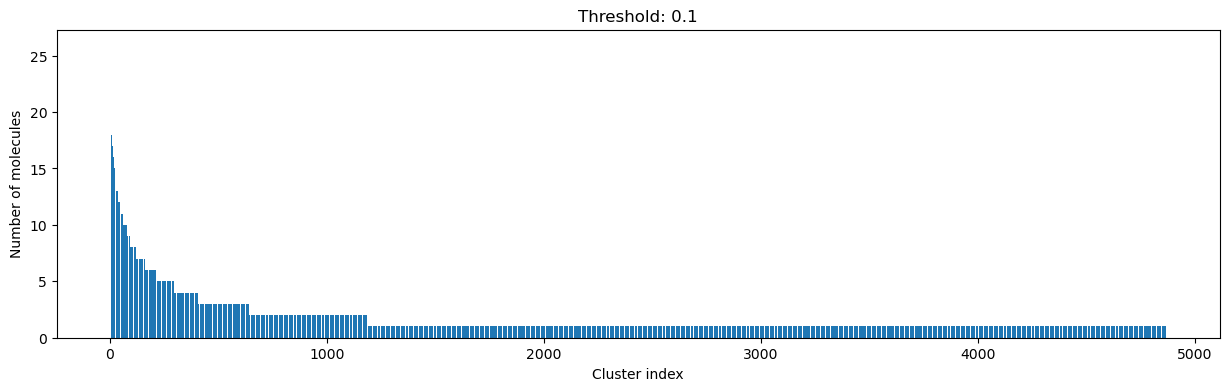

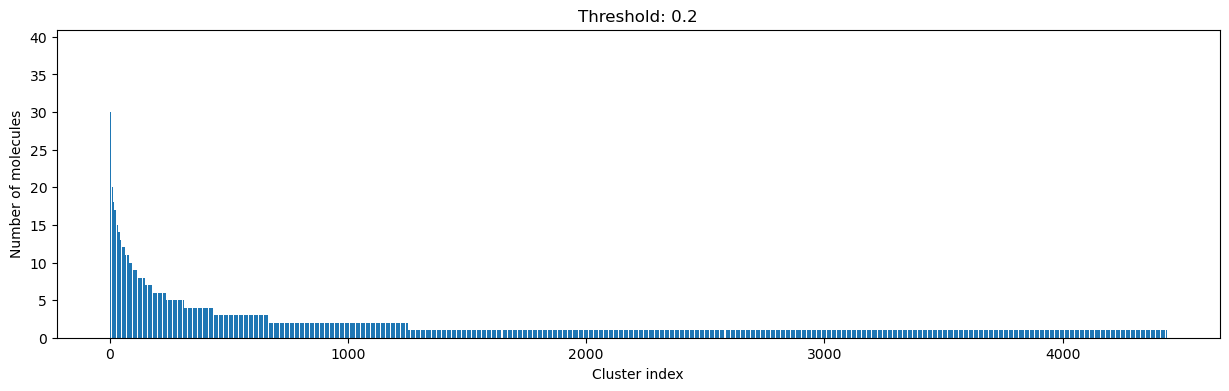

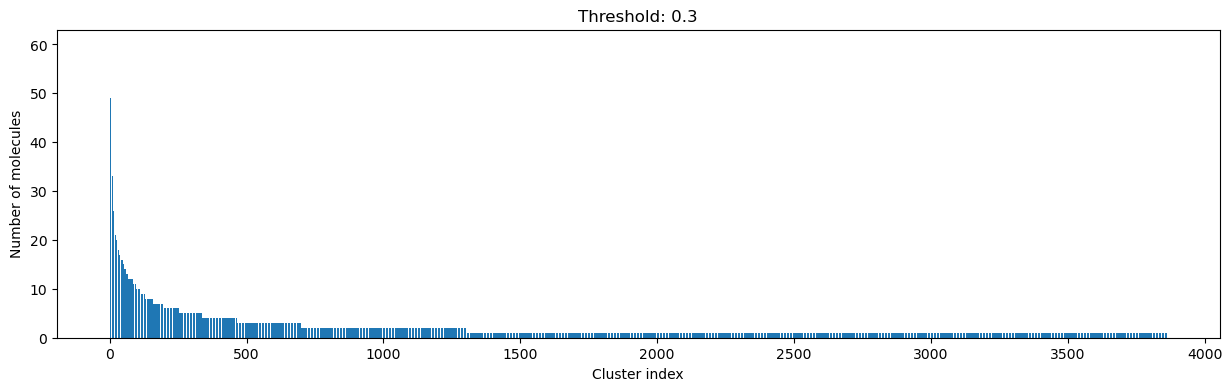

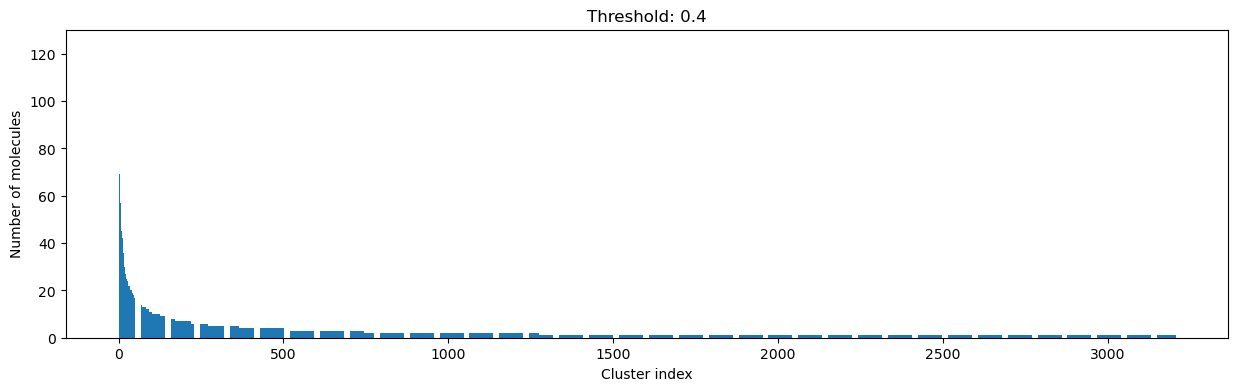

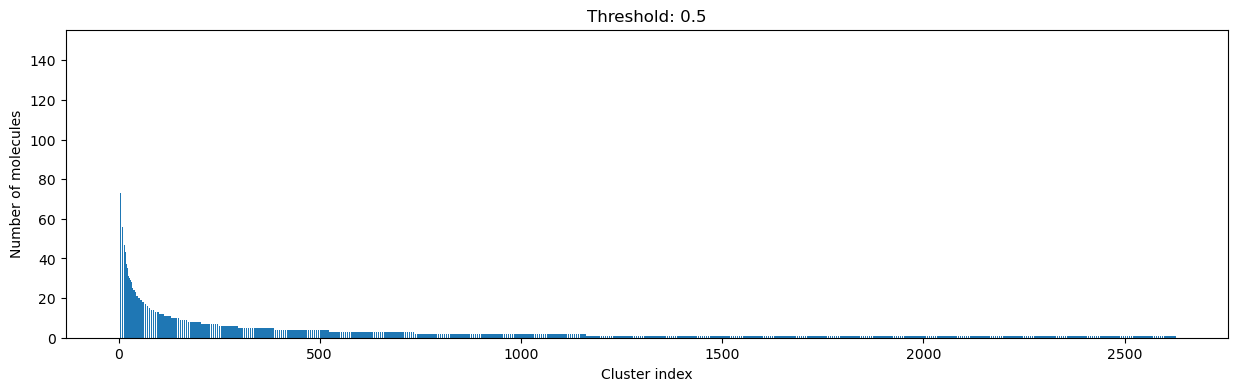

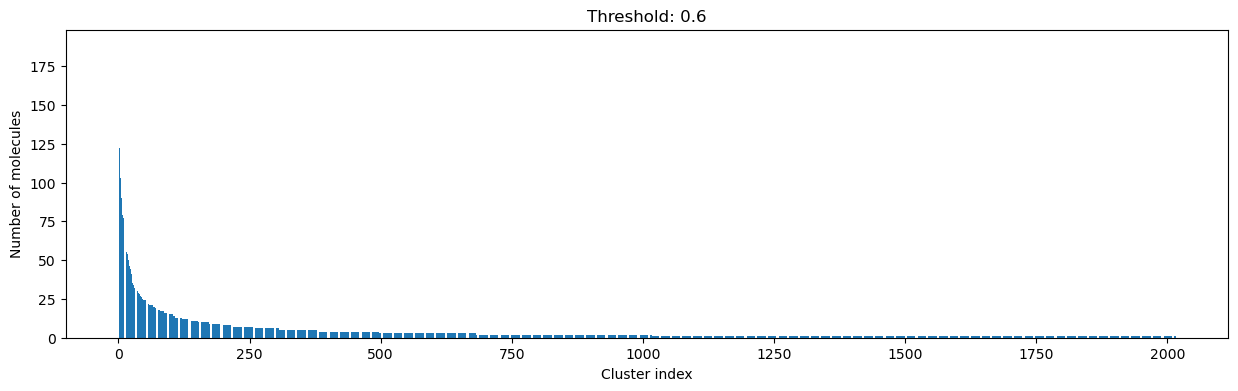

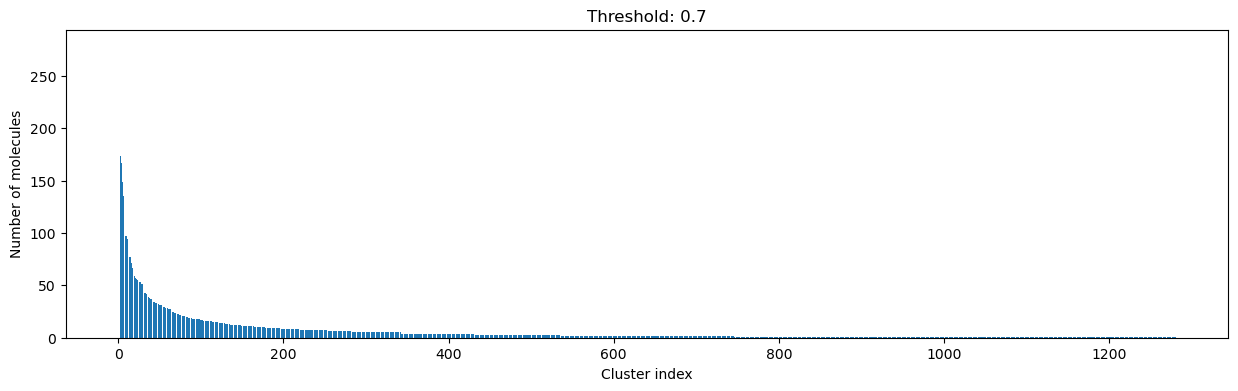

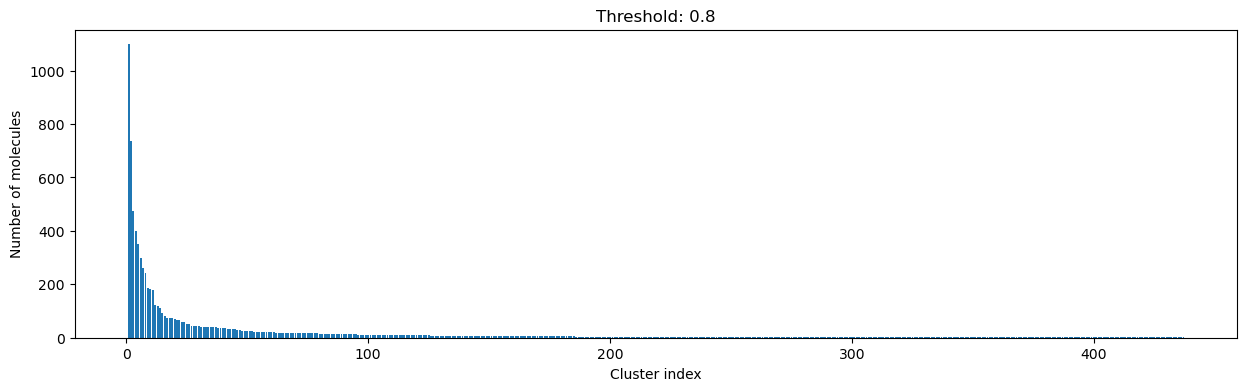

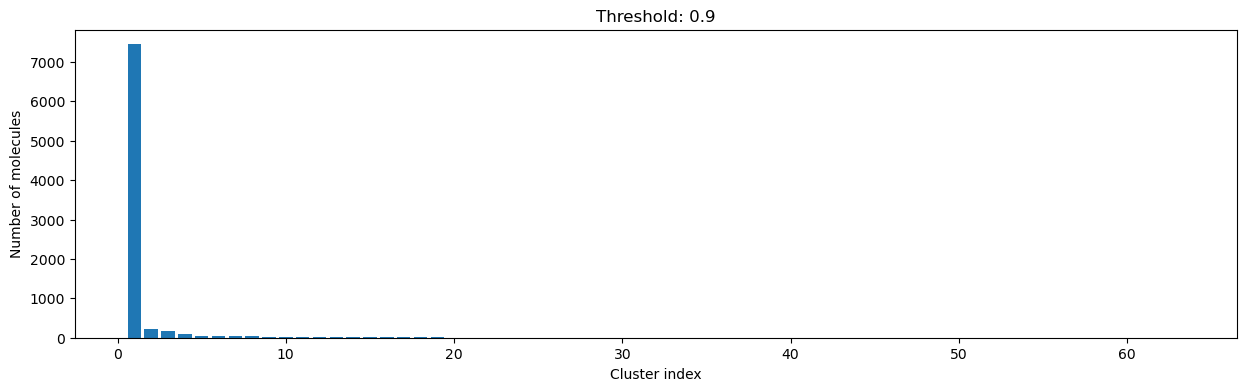

In [29]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = clusterFingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

/var/folders/42/vqc7rvcd6szg9qr3rjbnmnmc0000gn/T/ipykernel_8311/2568327084.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x="tags", y="n", palette="muted")


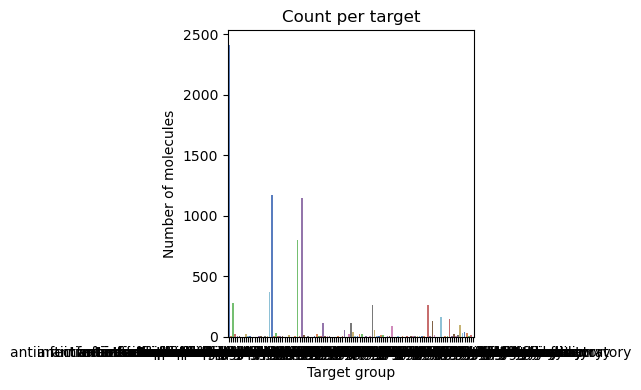

In [36]:
counts = data.groupby("tags")["smiles"].count().reset_index(name="n")

plt.figure(figsize=(6,4))
sns.barplot(data=counts, x="tags", y="n", palette="muted")
plt.ylabel("Number of molecules")
plt.xlabel("Target group")
plt.title("Count per target")
plt.tight_layout()
plt.show()